In [1]:
from datetime import datetime, timedelta
import numpy as np
import random
from infrastructure import Yard, Track, BigBlock
from signaling import AutoSignal, HomeSignal, AutoPoint, ControlPoint
from system import System
from train import Train
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
def string_diagram(sys):
    '''To draw the string diagram based on the schedule dictionary for all the trains. 
    '''
    plt.rcParams['figure.dpi'] = 200
    plt.ion()
    start_time, end_time = sys.init_time, sys.term_time
    colors = ['red','green','blue','black','orange','cyan','magenta']
    color_num = len(colors)
    t_color = [colors[i%color_num] for i in range(len(sys.trains))]
    x, y = [], []
    plt.clf()
    for i in range(len(sys.trains)):
        x.append([mdates.date2num(datetime.fromtimestamp(j)) for (j,_) in sys.trains[i].time_pos_list])
        y.append([j for (_,j) in sys.trains[i].time_pos_list])
        plt.plot([mdates.date2num(datetime.fromtimestamp(j)) for (j,_) in sys.trains[i].time_pos_list], \
                 [j for (_,j) in sys.trains[i].time_pos_list], color=t_color[i])

    train_idx = list(range(len(sys.trains)))
    min_t, max_t = min([i[0] for i in x if i]), max([i[-1] for i in x if i])

    
    plt.title('String Diagram')
    hours = mdates.HourLocator()
    minutes = mdates.MinuteLocator()
    seconds = mdates.SecondLocator()
    dateFmt = mdates.DateFormatter("%H:%M")
    plt.gca().xaxis.set_major_locator(hours)
    plt.gca().xaxis.set_minor_locator(minutes)
    plt.gca().xaxis.set_major_formatter(dateFmt)
    plt.xticks(rotation=90)
    plt.grid(True, linestyle = "-.", color = "r", linewidth = "0.1")
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Mile Post/miles')
    plt.axis([(datetime.fromtimestamp(start_time - 500)), \
            (datetime.fromtimestamp(end_time + 500)), -5 , 55])
# #     ===============================================================================
#     time_length = end_time - start_time
#     step_size = 10
#     for start in range(1,time_length + 1, step_size):
#         plt.axis([(datetime.fromtimestamp(start_time - 500)), \
#             (datetime.fromtimestamp(end_time + 500)), -5 , 55])
         
#         for n in range(len(x)-1):
#             new_x_y = [[mdates.date2num(datetime.fromtimestamp(i)), j] for i, j in zip(x[n], y[n]) if i < start_time + start and i > start_time + start - 1 - step_size]
#             new_x = []
#             new_y = []
#             for i , j in new_x_y:
#                 new_x.append(i)
#                 new_y.append(j)
#             if(len(new_x) == 0):
#                 continue
#             plt.plot(new_x, new_y, color=t_color[n])
#             # print('==============')
#             # print('Length of new_x: {}'.format(len(new_x)))
#             # print('Length of new_y: {}'.format(len(new_y)))
#         plt.pause(0.00001)
# #     ===============================================================================
    plt.gca().axhspan(15,20,color='yellow',alpha=0.5)
    plt.gca().axhspan(30,35,color='yellow',alpha=0.5)
    plt.gca().axvspan((datetime.fromtimestamp(start_time + 90 * 60)),(datetime.fromtimestamp(start_time + 150 * 60)),color='black',alpha=0.5)
    plt.pause(1)
    plt.ioff()
    plt.show()

def speed_curve(sys, train, scatter=False):
    '''To draw the speed curve based on a train's mileposts and speed . 
    '''
    colors = ['red','green','purple']
    mp, spd, spdlmt, tgt_spd = [], [], [], []
    for i in range(len(train.pos_spd_list)):
        mp.append(train.pos_spd_list[i][0])
        spd.append(abs(train.pos_spd_list[i][1]*3600))
        spdlmt.append(train.pos_spd_list[i][2]*3600)
        tgt_spd.append(train.pos_spd_list[i][3]*3600)

    min_mp, max_mp = min(mp), max(mp)
    
    plt.ion()
    plt.title('Speed Curve')
    plt.xticks(rotation=90)
    plt.grid(True, linestyle = "-.", color = "r", linewidth = "0.1")
    plt.legend()
    plt.xlabel('Mile Post/miles')
    plt.ylabel('MPH')
    if not scatter:
        plt.plot(mp, spd, color=colors[1])  # train speed
        plt.plot(mp, spdlmt, color=colors[0])  # train speed lmt
        plt.plot(mp, tgt_spd, '--', color=colors[2])  # train tgt speed
    if scatter:
        plt.scatter(mp, spd, color=colors[1])  # train speed
        plt.scatter(mp, spdlmt, color=colors[0])  # train speed lmt
        plt.scatter(mp, tgt_spd, color=colors[2])  # train tgt speed
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams['figure.dpi'] = 200
    import pylab; pylab.rcParams['figure.figsize'] = (15.0, 8.0)
    plt.pause(0.01)



In [2]:
sim_init_time = datetime.strptime('2018-01-10 10:00:00', "%Y-%m-%d %H:%M:%S")
sim_term_time = datetime.strptime('2018-01-10 15:30:00', "%Y-%m-%d %H:%M:%S")
sp_container = [random.uniform(0.01, 0.02) for i in range(20)]
acc_container = [0.5*random.uniform(2.78e-05*0.85, 2.78e-05*1.15) for i in range(20)]
dcc_container = [0.2*random.uniform(2.78e-05*0.85, 2.78e-05*1.15) for i in range(20)]
headway = 300 + random.random() * 400
sys = System(sim_init_time, sp_container, acc_container, dcc_container,
             term_time=sim_term_time,
             dos_period=['2018-01-10 11:30:00', '2018-01-10 12:30:00'],  
             dos_pos=(15,20),
             headway=headway, 
             refresh_time=50)


In [3]:
def sim():
    while sys.sys_time - sys.init_time <= sys.term_time - sys.init_time:
        sys.trains.sort()
        _semaphore_to_return = False
        for t in sys.trains:
            try:
                t.request_routing()
                t.update_acc()
            except:
                print(t)
                raise(ValueError("Raise a ValueError to stop"))
            
        if sys.sys_time - sys.last_train_init_time >= sys.headway:
            if not sys.signal_points[0].curr_train_with_route.keys():
                if all([t.curr_routing_path_segment != ((None,None),(sys.signal_points[0],0)) for t in sys.trains]):
                    if not sys.tracks[0].train:
                        t = sys.generate_train(sys.signal_points[0], 0, sys.signal_points[10], 1, length=1)
        sys.sys_time+=sys.refresh_time
sim()

train idx: 0, MP:  0.00 requested (0, 1) at CP: 0.0
	route (0, 1) of ControlPoint0 is opened
train idx: 0 initiated, entering into Track MP: 0.0 to MP: 5.0 idx: 0
	route (0, 1) of ControlPoint0 is closed
train idx: 0, MP:  0.06 requested (0, 1) at CP: 15.0
	route (0, 1) of ControlPoint3 is opened
train idx: 1, MP:  0.00 requested (0, 1) at CP: 0.0
	route (0, 1) of ControlPoint0 is opened
train idx: 1 initiated, entering into Track MP: 0.0 to MP: 5.0 idx: 0
	route (0, 1) of ControlPoint0 is closed
	route (0, 1) of ControlPoint3 is closed
train idx: 0, MP: 15.18 requested (0, 1) at CP: 20.0
	route (0, 1) of ControlPoint4 is opened
train idx: 1, MP:  4.55 requested (0, 3) at CP: 15.0
	route (0, 3) of ControlPoint3 is opened
train idx: 2, MP:  0.00 requested (0, 1) at CP: 0.0
	route (0, 1) of ControlPoint0 is opened
train idx: 2 initiated, entering into Track MP: 0.0 to MP: 5.0 idx: 0
	route (0, 1) of ControlPoint0 is closed
	route (0, 1) of ControlPoint4 is closed
train idx: 0, MP: 20.18 

train idx: 10, MP: 14.01 requested (0, 3) at CP: 15.0
	route (0, 3) of ControlPoint3 is opened
	route (0, 3) of ControlPoint3 is closed
	route (0, 1) of ControlPoint10 is closed
train idx: 5, MP: 19.97 requested (0, 1) at CP: 20.0
	route (0, 1) of ControlPoint4 is opened
	route (0, 1) of ControlPoint4 is closed
train idx: 13, MP:  0.00 requested (0, 1) at CP: 0.0
	route (0, 1) of ControlPoint0 is opened
train idx: 13 initiated, entering into Track MP: 0.0 to MP: 5.0 idx: 0
	route (0, 1) of ControlPoint0 is closed
train idx: 11, MP: 13.30 requested (0, 1) at CP: 15.0
	route (0, 1) of ControlPoint3 is opened
	route (0, 3) of ControlPoint6 is closed
train idx: 9, MP: 30.21 requested (2, 1) at CP: 35.0
	route (2, 1) of ControlPoint7 is opened
	route (0, 1) of ControlPoint3 is closed
train idx: 11, MP: 18.30 requested (0, 1) at CP: 20.0
	route (0, 1) of ControlPoint4 is opened
	route (2, 1) of ControlPoint7 is closed
train idx: 9, MP: 35.20 requested (0, 1) at CP: 50.0
	route (0, 1) of Cont

No handles with labels found to put in legend.


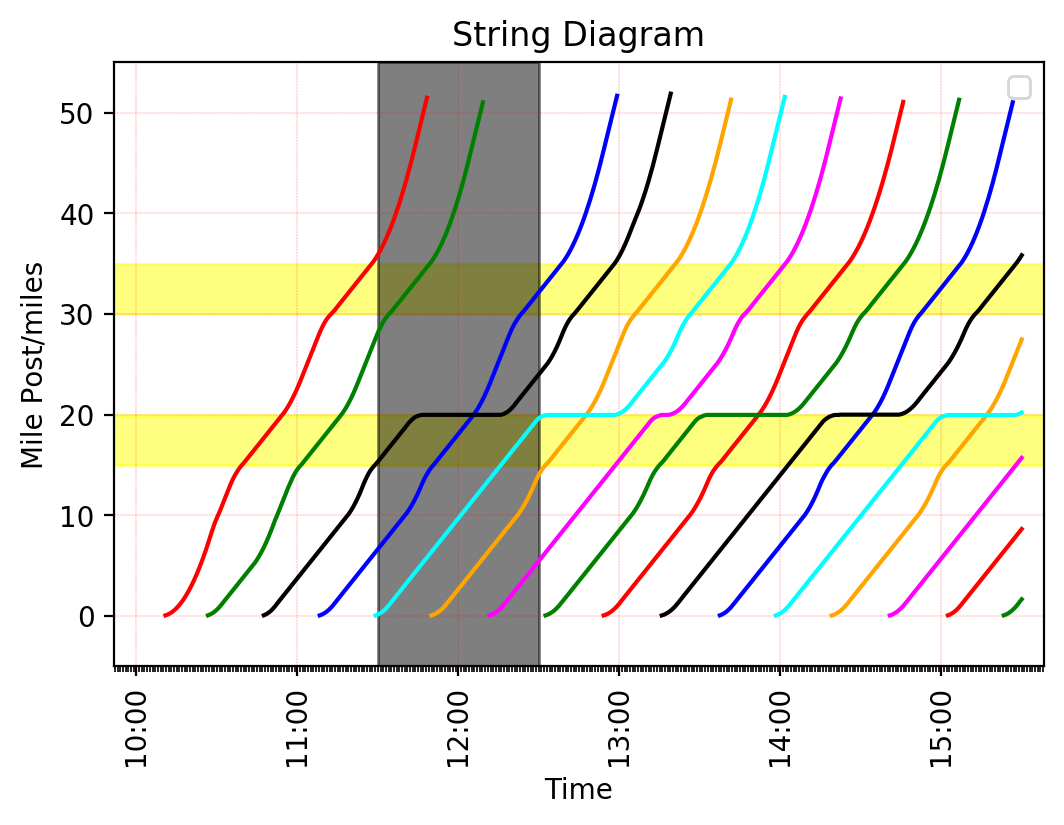

In [4]:
string_diagram(sys)

In [7]:
[t.rank-t.train_idx for t in sys.trains]

[0, 0, 0, -1, -1, 2, 0, -1, -1, 2, -1, -1, 2, 0, 0, 0]

In [21]:
[max([time for [time,_t] in t.time_pos_list]) for t in sys.trains][:8]

[1515610950.0,
 1515613450.0,
 1515608200.0,
 1515609600.0,
 1515604050.0,
 1515602600.0,
 1515612200.0,
 1515606450.0]

In [25]:
[t for (tt,t) in zip(tl, sys.trains[:8])]

[train index 6, current occupation: [((ControlPoint10, 1), (None, None))], head MP: 51.64, rear MP 50.64,
 train index 8, current occupation: [((ControlPoint10, 1), (None, None))], head MP: 51.45, rear MP 50.45,
 train index 4, current occupation: [((ControlPoint10, 1), (None, None))], head MP: 51.39, rear MP 50.39,
 train index 5, current occupation: [((ControlPoint10, 1), (None, None))], head MP: 51.34, rear MP 50.34,
 train index 1, current occupation: [((ControlPoint10, 1), (None, None))], head MP: 51.25, rear MP 50.25,
 train index 0, current occupation: [((ControlPoint10, 1), (None, None))], head MP: 51.20, rear MP 50.20,
 train index 2, current occupation: [((ControlPoint10, 1), (None, None))], head MP: 51.20, rear MP 50.20,
 train index 3, current occupation: [((ControlPoint10, 1), (None, None))], head MP: 51.00, rear MP 50.00]

In [26]:
sys.trains

[train index 6, current occupation: [((ControlPoint10, 1), (None, None))], head MP: 51.64, rear MP 50.64,
 train index 8, current occupation: [((ControlPoint10, 1), (None, None))], head MP: 51.45, rear MP 50.45,
 train index 4, current occupation: [((ControlPoint10, 1), (None, None))], head MP: 51.39, rear MP 50.39,
 train index 5, current occupation: [((ControlPoint10, 1), (None, None))], head MP: 51.34, rear MP 50.34,
 train index 1, current occupation: [((ControlPoint10, 1), (None, None))], head MP: 51.25, rear MP 50.25,
 train index 0, current occupation: [((ControlPoint10, 1), (None, None))], head MP: 51.20, rear MP 50.20,
 train index 2, current occupation: [((ControlPoint10, 1), (None, None))], head MP: 51.20, rear MP 50.20,
 train index 3, current occupation: [((ControlPoint10, 1), (None, None))], head MP: 51.00, rear MP 50.00,
 train index 10, current occupation: [((AutoPoint9, 1), (ControlPoint10, 0))], head MP: 49.53, rear MP 48.53,
 train index 9, current occupation: [((Con

In [5]:
1

1

In [20]:
while True:
    if objecttrain.curr_MP>50:
        break
    sys.trains.sort()
    for t in sys.trains:
        try:
            t.request_routing()
            t.update_acc()
        except:
            print(t)
            raise(ValueError("Raise a ValueError to stop"))
    sys.sys_time+=sys.refresh_time
    

route (0, 1) of ControlPoint7 is closed
train index 2, current occupation: [((ControlPoint7, 1), (AutoPoint8, 0)), ((ControlPoint6, 1), (ControlPoint7, 0))], head MP: 35.19, rear MP 34.19 requested (0, 1) at ControlPoint10
route (0, 1) of ControlPoint10 is opened
route (0, 3) of ControlPoint6 is closed
train index 1, current occupation: [((ControlPoint6, 3), (ControlPoint7, 2))], head MP: 31.58, rear MP 30.58 requested (2, 1) at ControlPoint7
route (2, 1) of ControlPoint7 is opened
route (0, 1) of ControlPoint10 is closed
route (2, 1) of ControlPoint7 is closed
train index 1, current occupation: [((ControlPoint7, 1), (AutoPoint8, 0)), ((ControlPoint6, 3), (ControlPoint7, 2))], head MP: 35.19, rear MP 34.19 requested (0, 1) at ControlPoint10
route (0, 1) of ControlPoint10 is opened
route (0, 1) of ControlPoint10 is closed


In [43]:
# [trk.train for trk in objecttrain.curr_track.yard.tracks]
following_train.max_speed == max([trn.max_speed for trn in objecttrain.curr_track.yard.all_trains])

True

In [28]:
sys.get_trains_between_points(to_point=sys.signal_points[10], sys.signal_points[3], obv=True)

[train index 0, current occupation: [((AutoPoint9, 0), (AutoPoint8, 1))], head MP: 40.00, rear MP 41.00,
 train index 1, current occupation: [((ControlPoint6, 0), (AutoPoint5, 1))], head MP: 25.00, rear MP 26.00]

In [10]:
print(K166)
print(T166)
print(K165)
print(T165)

train index 0, current occupation: [((ControlPoint4, 0), (ControlPoint3, 1))], head MP: 16.98, rear MP 17.98
train index 1, current occupation: [((ControlPoint4, 2), (ControlPoint3, 3))], head MP: 15.00, rear MP 16.00
train index 2, current occupation: [((AutoPoint2, 1), (ControlPoint3, 0))], head MP: 15.00, rear MP 14.00
train index 3, current occupation: [((ControlPoint10, 1), (None, None)), ((AutoPoint9, 1), (ControlPoint10, 0))], head MP: 50.07, rear MP 49.07


In [27]:
sys.num_parallel_tracks(init_point, dest_point=sys.signal_points[0])

1

In [12]:
T165.curr_control_point.available_ports_by_port[1]

[]

In [14]:
K165.stopped

True

In [13]:
sys.signal_points[7].available_ports_by_port

defaultdict(list, {0: [1], 2: [1], 1: [2]})

In [4]:
print('T166: stopped: {}, \tcurr_MP: {}, \tcurr_spd: {}, \ttgt_spd: {},\tnum_blk_ahead: {}, \taspect: {},'.format(T166.stopped,\
                                                                str("%.2f" % round(T166.curr_MP,2)).rjust(5,' '), \
                                                               "%.2f" % round(T166.curr_speed*3600,2), \
                                                               "%.2f" % round(T166.curr_target_spd_abs*3600,2), \
                                                               T166.curr_sig.number_of_blocks_cleared_ahead, \
                                                               T166.curr_sig.aspect))
print('K166: stopped: {}, \tcurr_MP: {}, \tcurr_spd: {}, \ttgt_spd: {},\tnum_blk_ahead: {}, \taspect: {},'.format(K166.stopped,\
                                                                str("%.2f" % round(K166.curr_MP,2)).rjust(5,' '), \
                                                               "%.2f" % round(K166.curr_speed*3600,2), \
                                                               "%.2f" % round(K166.curr_target_spd_abs*3600,2), \
                                                               K166.curr_sig.number_of_blocks_cleared_ahead, \
                                                               K166.curr_sig.aspect))

T166: stopped: True, 	curr_MP:  0.00, 	curr_spd: 0.00, 	tgt_spd: 0.00,	num_blk_ahead: 0, 	aspect: Aspect: r, 	 route None, target speed 0.0 mph,


NameError: name 'K166' is not defined

In [11]:
for t in sys.tracks:
    print(t.routing,t.train)
print('\n')
for b in sys.bigblocks:
    print(b.routing)

((ControlPoint0, 1), (AutoPoint1, 0)) []
((AutoPoint1, 1), (AutoPoint2, 0)) []
((AutoPoint2, 1), (ControlPoint3, 0)) [train index 1, current occupying sections: [((AutoPoint2, 1), (ControlPoint3, 0))], head MP: 15.00, rear MP 14.00]
None []
None []
None []
None []
None []
None []
None []
None []
None []


((ControlPoint0, 1), (ControlPoint3, 0))
None
None
None
None
None
None


In [69]:
sys.G_origin[sys.signal_points[0]][sys.signal_points[1]][0]['instance'].train

[]

In [23]:
repr(1)

'1'

In [5]:
from infrastructure import Track, BigBlock
from system import System
from train import Train
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np


def string_diagram(sys):
    '''To draw the string diagram based on the schedule dictionary for all the trains. 
    '''
    plt.rcParams['figure.dpi'] = 200
    plt.ion()
    start_time, end_time = sys.init_time, sys.term_time
    colors = ['red','green','blue','black','orange','cyan','magenta']
    color_num = len(colors)
    t_color = [colors[i%color_num] for i in range(len(sys.trains))]
    x, y = [], []
    plt.clf()
    for i in range(len(sys.trains)):
        x.append([mdates.date2num(datetime.fromtimestamp(j)) for (j,_) in sys.trains[i].time_pos_list])
        y.append([j for (_,j) in sys.trains[i].time_pos_list])
        plt.plot([mdates.date2num(datetime.fromtimestamp(j)) for (j,_) in sys.trains[i].time_pos_list], \
                 [j for (_,j) in sys.trains[i].time_pos_list], color=t_color[i])

    train_idx = list(range(len(sys.trains)))
    min_t, max_t = min([i[0] for i in x if i]), max([i[-1] for i in x if i])

    
    plt.title('String Diagram')
    hours = mdates.HourLocator()
    minutes = mdates.MinuteLocator()
    seconds = mdates.SecondLocator()
    dateFmt = mdates.DateFormatter("%H:%M")
    plt.gca().xaxis.set_major_locator(hours)
    plt.gca().xaxis.set_minor_locator(minutes)
    plt.gca().xaxis.set_major_formatter(dateFmt)
    plt.xticks(rotation=90)
    plt.grid(True, linestyle = "-.", color = "r", linewidth = "0.1")
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Mile Post/miles')
    plt.axis([(datetime.fromtimestamp(start_time - 500)), \
            (datetime.fromtimestamp(end_time + 500)), -5 , 55])
# #     ===============================================================================
#     time_length = end_time - start_time
#     step_size = 10
#     for start in range(1,time_length + 1, step_size):
#         plt.axis([(datetime.fromtimestamp(start_time - 500)), \
#             (datetime.fromtimestamp(end_time + 500)), -5 , 55])
         
#         for n in range(len(x)-1):
#             new_x_y = [[mdates.date2num(datetime.fromtimestamp(i)), j] for i, j in zip(x[n], y[n]) if i < start_time + start and i > start_time + start - 1 - step_size]
#             new_x = []
#             new_y = []
#             for i , j in new_x_y:
#                 new_x.append(i)
#                 new_y.append(j)
#             if(len(new_x) == 0):
#                 continue
#             plt.plot(new_x, new_y, color=t_color[n])
#             # print('==============')
#             # print('Length of new_x: {}'.format(len(new_x)))
#             # print('Length of new_y: {}'.format(len(new_y)))
#         plt.pause(0.00001)
# #     ===============================================================================
    plt.gca().axhspan(15,20,color='yellow',alpha=0.5)
    plt.gca().axhspan(30,35,color='yellow',alpha=0.5)
    plt.gca().axvspan((datetime.fromtimestamp(start_time + 90 * 60)),(datetime.fromtimestamp(start_time + 150 * 60)),color='black',alpha=0.5)
    plt.pause(1)
    plt.ioff()
    plt.show()

def speed_curve(sys, train):
    '''To draw the speed curve based on a train's mileposts and speed . 
    '''
    colors = ['red','green','purple']
    mp, spd, spdlmt, tgt_spd = [], [], [], []
    for i in range(len(train.pos_spd_list)):
        mp.append(train.pos_spd_list[i][0])
        spd.append(abs(train.pos_spd_list[i][1]*3600))
        spdlmt.append(train.pos_spd_list[i][2]*3600)
        tgt_spd.append(train.pos_spd_list[i][3]*3600)

    min_mp, max_mp = min(mp), max(mp)
    
    plt.ion()
    plt.title('Speed Curve')
    plt.xticks(rotation=90)
    plt.grid(True, linestyle = "-.", color = "r", linewidth = "0.1")
    plt.legend()
    plt.xlabel('Mile Post/miles')
    plt.ylabel('MPH')
    plt.plot(mp, spd, color=colors[1])  # train speed
    plt.plot(mp, spdlmt, color=colors[0])  # train speed lmt
    plt.plot(mp, tgt_spd, '--', color=colors[2])  # train tgt speed
    
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams['figure.dpi'] = 200
    import pylab; pylab.rcParams['figure.figsize'] = (15.0, 8.0)
    plt.pause(0.01)
    #plt.ioff()


In [13]:
print(K166)
print(T166)
print(K165)
print(T165)

train index 0, current occupation: [((None, None), (ControlPoint10, 1))], head MP: 50.00, rear MP 51.00
train index 1, current occupation: [((ControlPoint10, 0), (AutoPoint9, 1))], head MP: 46.90, rear MP 47.90
train index 2, current occupation: [((None, None), (ControlPoint0, 0))], head MP:  0.00, rear MP -1.00
train index 3, current occupation: [((ControlPoint0, 1), (AutoPoint1, 0))], head MP:  2.94, rear MP  1.94


No handles with labels found to put in legend.


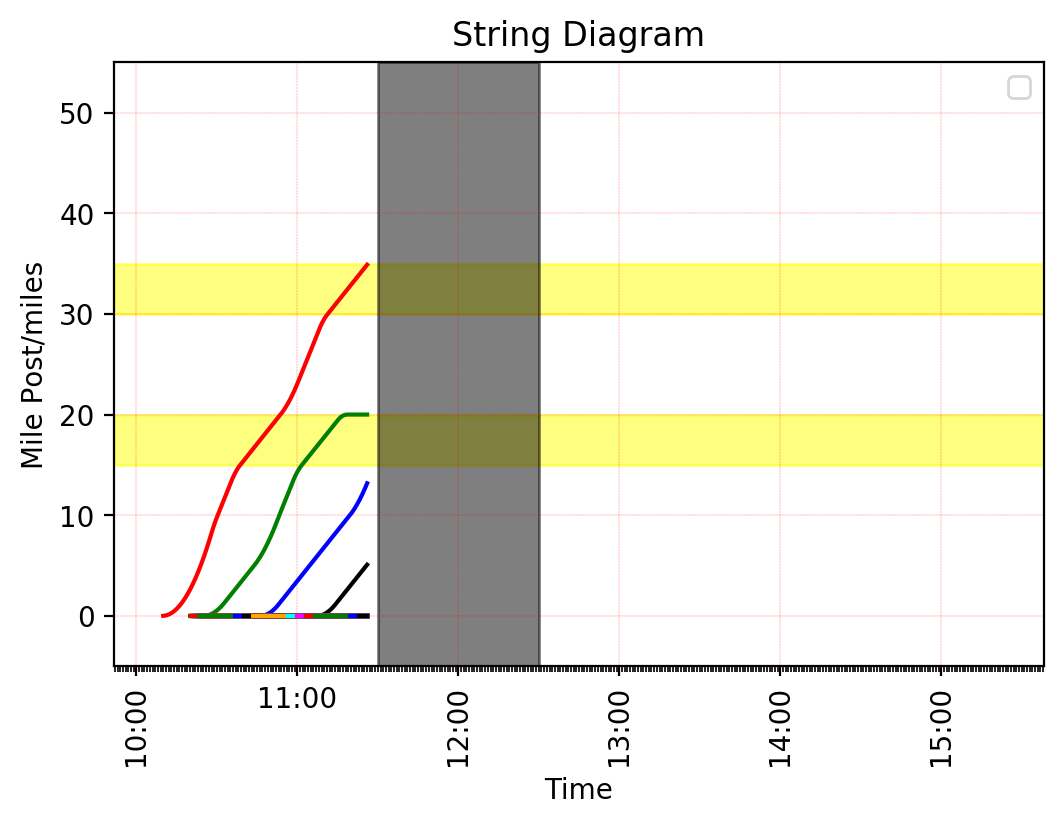

In [18]:
string_diagram(sys)

In [20]:
_enterable=True
for n in T165.system.control_points:
    if (n.MP - T165.curr_control_point.MP) * T165.sign_MP(T165.curr_routing_path_segment) > 0:
        if not T165.system.capacity_enterable(T165.curr_control_point, n):
            _enterable=False
print(_enterable)

True


In [27]:
T165.curr_control_point.current_routes

[(1, 0)]

In [14]:
r

((ControlPoint10, 0), (ControlPoint7, None))

In [31]:
delta_s = T166.curr_speed * T166.system.refresh_time + 0.5 * (-T166.max_acc) * T166.system.refresh_time**2

In [32]:
(T166.curr_sig.MP-T166.curr_MP)*(T166.curr_sig.MP-(T166.curr_MP+delta_s))

-0.06333881577705458

In [ ]:
print(sys.trains)
sys.signal_points[0].open_route((0,1))
sys.signal_points[10].open_route((1,0))
while T165.rear_curr_MP<=0 and T166.rear_curr_MP>=50:
    T166.update_acc()
    T165.update_acc()
    K166.update_acc()
    K165.update_acc()
    sys.sys_time+=sys.refresh_time
sys.signal_points[0].open_route((0,1))
sys.signal_points[10].open_route((1,0))
# both all the trains to enter the system
sys.signal_points[7].open_route((1,2))
sys.signal_points[6].open_route((0,1))
sys.signal_points[3].open_route((0,1))
sys.signal_points[4].open_route((0,1))
# T166 to meet T165 at siding 2
while T165.rear_curr_MP<=15:
    T166.update_acc()
    T165.update_acc()
    K166.update_acc()
    K165.update_acc()
    sys.sys_time+=sys.refresh_time
sys.signal_points[3].open_route((0,3))
while T165.rear_curr_MP<=30:
    T166.update_acc()
    T165.update_acc()
    K166.update_acc()
    K165.update_acc()
    sys.sys_time+=sys.refresh_time  
sys.signal_points[6].open_route((3,0))
sys.signal_points[4].open_route((1,0))
while T166.rear_curr_MP>=30:
    T166.update_acc()
    T165.update_acc()
    K166.update_acc()
    K165.update_acc()
    sys.sys_time+=sys.refresh_time  
sys.signal_points[7].open_route((1,2))
while K166.rear_curr_MP>=35:
    T166.update_acc()
    T165.update_acc()
    K166.update_acc()
    K165.update_acc()
    sys.sys_time+=sys.refresh_time
sys.signal_points[6].open_route((3,0))   
sys.signal_points[7].open_route((0,1))   
sys.signal_points[10].open_route((0,1))
while T166.rear_curr_MP>=20:
    T166.update_acc()
    T165.update_acc()
    K166.update_acc()
    K165.update_acc()
    sys.sys_time+=sys.refresh_time
sys.signal_points[4].open_route((2,1))
sys.signal_points[6].open_route((3,0))
sys.signal_points[3].open_route((1,0))
sys.signal_points[0].open_route((1,0))
while T165.rear_curr_MP<=50:
    T166.update_acc()
    T165.update_acc()
    K166.update_acc()
    K165.update_acc()
    sys.sys_time+=sys.refresh_time
sys.signal_points[10].open_route((0,1))
while K165.rear_curr_MP<=50:
    T166.update_acc()
    T165.update_acc()
    K166.update_acc()
    K165.update_acc()
    sys.sys_time+=sys.refresh_time

# while T166.rear_curr_MP>=30:
#     T166.update_acc()
#     T165.update_acc()
#     K166.update_acc()
#     K165.update_acc()
#     sys.sys_time+=sys.refresh_time
# sys.signal_points[7].open_route((1,2))
# while K166.rear_curr_MP>=35:
#     T166.update_acc()
#     T165.update_acc()
#     K166.update_acc()
#     K165.update_acc()
#     sys.sys_time+=sys.refresh_time
# sys.signal_points[6].open_route((3,0))
# sys.signal_points[4].open_route((3,0))    
# sys.signal_points[7].open_route((0,1))
# sys.signal_points[10].open_route((0,1))


# sys.signal_points[10].open_route((1,0))
# sys.signal_points[7].open_route((1,0))
# sys.signal_points[6].open_route((1,0))
# sys.signal_points[4].open_route((1,0))
# count=0
# while T166.rear_curr_MP>20:
#     count+=1
#     T166.update_acc()
#     T165.update_acc()
#     sys.sys_time+=sys.refresh_time
# print(count)
# sys.signal_points[0].open_route((1,0))
# sys.signal_points[3].open_route((1,0))
# sys.signal_points[10].open_route((0,1))
# sys.signal_points[7].open_route((0,1))
# sys.signal_points[6].open_route((0,1))
# sys.signal_points[4].open_route((2,1))
# count=0
# while not T165.stopped:
#     count+=1
#     T166.update_acc()
#     T165.update_acc()
#     sys.sys_time+=sys.refresh_time
# print(count)

In [17]:
###################################################################
#                                                                 #
#                     PLOTTING A LIVE GRAPH                       #
#                  ----------------------------                   #
#            EMBED A MATPLOTLIB ANIMATION INSIDE YOUR             #
#            OWN GUI!                                             #
#                                                                 #
###################################################################


import sys
import os
from PyQt4 import QtGui
from PyQt4 import QtCore
import functools
import numpy as np
import random as rd
import matplotlib
matplotlib.use("Qt4Agg")
from matplotlib.figure import Figure
from matplotlib.animation import TimedAnimation
from matplotlib.lines import Line2D
from matplotlib.backends.backend_qt4agg import FigureCanvasQTAgg as FigureCanvas
import time
import threading



def setCustomSize(x, width, height):
    sizePolicy = QtGui.QSizePolicy(QtGui.QSizePolicy.Fixed, QtGui.QSizePolicy.Fixed)
    sizePolicy.setHorizontalStretch(0)
    sizePolicy.setVerticalStretch(0)
    sizePolicy.setHeightForWidth(x.sizePolicy().hasHeightForWidth())
    x.setSizePolicy(sizePolicy)
    x.setMinimumSize(QtCore.QSize(width, height))
    x.setMaximumSize(QtCore.QSize(width, height))

''''''

class CustomMainWindow(QtGui.QMainWindow):

    def __init__(self):

        super(CustomMainWindow, self).__init__()

        # Define the geometry of the main window
        self.setGeometry(300, 300, 800, 400)
        self.setWindowTitle("my first window")

        # Create FRAME_A
        self.FRAME_A = QtGui.QFrame(self)
        self.FRAME_A.setStyleSheet("QWidget { background-color: %s }" % QtGui.QColor(210,210,235,255).name())
        self.LAYOUT_A = QtGui.QGridLayout()
        self.FRAME_A.setLayout(self.LAYOUT_A)
        self.setCentralWidget(self.FRAME_A)

        # Place the zoom button
        self.zoomBtn = QtGui.QPushButton(text = 'zoom')
        setCustomSize(self.zoomBtn, 100, 50)
        self.zoomBtn.clicked.connect(self.zoomBtnAction)
        self.LAYOUT_A.addWidget(self.zoomBtn, *(0,0))

        # Place the matplotlib figure
        self.myFig = CustomFigCanvas()
        self.LAYOUT_A.addWidget(self.myFig, *(0,1))

        # Add the callbackfunc to ..
        myDataLoop = threading.Thread(name = 'myDataLoop', target = dataSendLoop, daemon = True, args = (self.addData_callbackFunc,))
        myDataLoop.start()

        self.show()

    ''''''


    def zoomBtnAction(self):
        print("zoom in")
        self.myFig.zoomIn(5)

    ''''''

    def addData_callbackFunc(self, value):
        # print("Add data: " + str(value))
        self.myFig.addData(value)



''' End Class '''


class CustomFigCanvas(FigureCanvas, TimedAnimation):

    def __init__(self):

        self.addedData = []
        print(matplotlib.__version__)

        # The data
        self.xlim = 200
        self.n = np.linspace(0, self.xlim - 1, self.xlim)
        a = []
        b = []
        a.append(2.0)
        a.append(4.0)
        a.append(2.0)
        b.append(4.0)
        b.append(3.0)
        b.append(4.0)
        self.y = (self.n * 0.0) + 50

        # The window
        self.fig = Figure(figsize=(5,5), dpi=100)
        self.ax1 = self.fig.add_subplot(111)


        # self.ax1 settings
        self.ax1.set_xlabel('time')
        self.ax1.set_ylabel('raw data')
        self.line1 = Line2D([], [], color='blue')
        self.line1_tail = Line2D([], [], color='red', linewidth=2)
        self.line1_head = Line2D([], [], color='red', marker='o', markeredgecolor='r')
        self.ax1.add_line(self.line1)
        self.ax1.add_line(self.line1_tail)
        self.ax1.add_line(self.line1_head)
        self.ax1.set_xlim(0, self.xlim - 1)
        self.ax1.set_ylim(0, 100)


        FigureCanvas.__init__(self, self.fig)
        TimedAnimation.__init__(self, self.fig, interval = 50, blit = True)

    def new_frame_seq(self):
        return iter(range(self.n.size))

    def _init_draw(self):
        lines = [self.line1, self.line1_tail, self.line1_head]
        for l in lines:
            l.set_data([], [])

    def addData(self, value):
        self.addedData.append(value)

    def zoomIn(self, value):
        bottom = self.ax1.get_ylim()[0]
        top = self.ax1.get_ylim()[1]
        bottom += value
        top -= value
        self.ax1.set_ylim(bottom,top)
        self.draw()


    def _step(self, *args):
        # Extends the _step() method for the TimedAnimation class.
        try:
            TimedAnimation._step(self, *args)
        except Exception as e:
            self.abc += 1
            print(str(self.abc))
            TimedAnimation._stop(self)
            pass

    def _draw_frame(self, framedata):
        margin = 2
        while(len(self.addedData) > 0):
            self.y = np.roll(self.y, -1)
            self.y[-1] = self.addedData[0]
            del(self.addedData[0])


        self.line1.set_data(self.n[ 0 : self.n.size - margin ], self.y[ 0 : self.n.size - margin ])
        self.line1_tail.set_data(np.append(self.n[-10:-1 - margin], self.n[-1 - margin]), np.append(self.y[-10:-1 - margin], self.y[-1 - margin]))
        self.line1_head.set_data(self.n[-1 - margin], self.y[-1 - margin])
        self._drawn_artists = [self.line1, self.line1_tail, self.line1_head]



''' End Class '''


# You need to setup a signal slot mechanism, to 
# send data to your GUI in a thread-safe way.
# Believe me, if you don't do this right, things
# go very very wrong..
class Communicate(QtCore.QObject):
    data_signal = QtCore.pyqtSignal(float)

''' End Class '''



def dataSendLoop(addData_callbackFunc):
    # Setup the signal-slot mechanism.
    mySrc = Communicate()
    mySrc.data_signal.connect(addData_callbackFunc)

    # Simulate some data
    n = np.linspace(0, 499, 500)
    y = 50 + 25*(np.sin(n / 8.3)) + 10*(np.sin(n / 7.5)) - 5*(np.sin(n / 1.5))
    i = 0

    while(True):
        if(i > 499):
            i = 0
        time.sleep(0.1)
        mySrc.data_signal.emit(y[i]) # <- Here you emit a signal!
        i += 1
    ###
###




if __name__== '__main__':
    app = QtGui.QApplication(sys.argv)
    QtGui.QApplication.setStyle(QtGui.QStyleFactory.create('Plastique'))
    myGUI = CustomMainWindow()


    sys.exit(app.exec_())

''''''

FileNotFoundError: [Errno 2] No such file or directory: '/Library/Fonts/Songti.ttc'

FileNotFoundError: [Errno 2] No such file or directory: '/Library/Fonts/Songti.ttc'

<Figure size 640x480 with 1 Axes>

In [16]:
x = np.linspace(0, 2 * np.pi, 100)

In [18]:
[i for i in x]

[0.0,
 0.06346651825433926,
 0.12693303650867852,
 0.1903995547630178,
 0.25386607301735703,
 0.3173325912716963,
 0.3807991095260356,
 0.4442656277803748,
 0.5077321460347141,
 0.5711986642890533,
 0.6346651825433925,
 0.6981317007977318,
 0.7615982190520711,
 0.8250647373064104,
 0.8885312555607496,
 0.9519977738150889,
 1.0154642920694281,
 1.0789308103237674,
 1.1423973285781066,
 1.2058638468324459,
 1.269330365086785,
 1.3327968833411243,
 1.3962634015954636,
 1.4597299198498028,
 1.5231964381041423,
 1.5866629563584815,
 1.6501294746128208,
 1.71359599286716,
 1.7770625111214993,
 1.8405290293758385,
 1.9039955476301778,
 1.967462065884517,
 2.0309285841388562,
 2.0943951023931957,
 2.1578616206475347,
 2.221328138901874,
 2.284794657156213,
 2.3482611754105527,
 2.4117276936648917,
 2.475194211919231,
 2.53866073017357,
 2.6021272484279097,
 2.6655937666822487,
 2.729060284936588,
 2.792526803190927,
 2.8559933214452666,
 2.9194598396996057,
 2.982926357953945,
 3.0463928762082

In [19]:
def foo():
    def bar():
        print(spam)

    spam = 'ham'
    bar()
    spam = 'eggs'
    bar()
    return bar

b = foo()
b()

ham
eggs
eggs


In [48]:
for i in dir(b.__closure__[0]):
    print(getattr(b,i,None))

<class 'function'>
<method-wrapper '__delattr__' of function object at 0x000002A0F9F6A840>
<built-in method __dir__ of function object at 0x000002A0F9F6A840>
None
<method-wrapper '__eq__' of function object at 0x000002A0F9F6A840>
<built-in method __format__ of function object at 0x000002A0F9F6A840>
<method-wrapper '__ge__' of function object at 0x000002A0F9F6A840>
<method-wrapper '__getattribute__' of function object at 0x000002A0F9F6A840>
<method-wrapper '__gt__' of function object at 0x000002A0F9F6A840>
<method-wrapper '__hash__' of function object at 0x000002A0F9F6A840>
<method-wrapper '__init__' of function object at 0x000002A0F9F6A840>
<built-in method __init_subclass__ of type object at 0x00007FFBFC7B3240>
<method-wrapper '__le__' of function object at 0x000002A0F9F6A840>
<method-wrapper '__lt__' of function object at 0x000002A0F9F6A840>
<method-wrapper '__ne__' of function object at 0x000002A0F9F6A840>
<built-in method __new__ of type object at 0x00007FFBFC7B3240>
<built-in meth

In [47]:
b.__closure__[0].cell_contents

'eggs'

In [72]:
 [1]

SyntaxError: unexpected EOF while parsing (<ipython-input-72-e2f2b05ad91f>, line 1)

In [8]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-

"""
Py40 PyQt5 tutorial 

This program creates a quit
button. When we press the button,
the application terminates. 

author: Jan Bodnar
website: py40.com 
last edited: January 2015
"""

import sys
from PyQt5.QtWidgets import QWidget, QPushButton, QApplication
from PyQt5.QtCore import QCoreApplication


class Example(QWidget):
    
    def __init__(self):
        super().__init__()
        
        self.initUI()
        
        
    def initUI(self):               
        
        qbtn = QPushButton('Quit', self)
        qbtn.clicked.connect(QCoreApplication.instance().quit)
        qbtn.resize(qbtn.sizeHint())
        qbtn.move(50, 50)       
        
        self.setGeometry(300, 300, 250, 150)
        self.setWindowTitle('Quit button')    
        self.show()
        
        
if __name__ == '__main__':
    
    app = QApplication(sys.argv)
    ex = Example()
    sys.exit(app.exec_())

SystemExit: 0

C:\Users\Hegxiten\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
